In [ ]:
import os
import gym
import pylab
import random
import numpy as np
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam, RMSprop

In [ ]:
num_states = 10
prob_next = 0.3
prob_prev = 0.3
prob_self = 1- (prob_next + prob_prev)
prob_edge = 0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
prob_matrix = np.zeros((num_states,3))

for i in range(num_states):
  if i == 0:
    prob_matrix[i][0] = 0
    prob_matrix[i][1] = prob_edge
    prob_matrix[i][2] = 1-prob_edge

  elif i == num_states-1:
    prob_matrix[i][0] = 1-prob_edge
    prob_matrix[i][1] = prob_edge
    prob_matrix[i][2] = 0

  else:
    prob_matrix[i][0] = prob_prev
    prob_matrix[i][1] = prob_self
    prob_matrix[i][2] = prob_next

In [ ]:
prob_matrix

array([[0. , 0.2, 0.8],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.8, 0.2, 0. ]])

In [ ]:
Es=20
power_max=100
battery_max = 100
gain_max = 1.0
battery_factor = 0.3
discount_factor = 0.95

### Agent

In [ ]:
class Agent(): # actions of agent depends on policy, here we compute what happens after action
  def __init__(self):
    self.noise = 1.0
    self.gain_factor = 1 # power_max / num_states
    self.battery_prob = 0.5 # battery renew prob

  def channel_next_state(self,i):  # channel transition and it is independent of action

    prob = np.random.rand()

    if i == 1:
      # state 1,
      if prob > prob_edge: # retain same state, that is 1
        return 0
      else:
        return 1 # go to next state

    elif i == num_states: # next state from last state
      if prob > prob_edge:   # retain same state, that is last state
        return 0
      else:
        return -1 # go one state back

    else:
      if prob < prob_prev: # go to previous state
        return -1
      elif prob < prob_prev + prob_self: # retain the same state
        return 0
      else: # go to next state
        return 1

  def state_battery(self,battery,power_transmit): # battery remains and harvesting
  # transition of state: battery level
  # inputs are battery level and action tx power
    rand = np.random.rand()
    is_harvested = -1 # random initialization

    battery_spent = battery_factor * power_transmit # this is known if tx power is fixed

    if rand < self.battery_prob: # this is battery harvesting condition
      new_battery = np.minimum(power_max,battery + Es - battery_spent)
      new_battery = max(0,new_battery)
      is_harvested = 1

    else: # no battery harvesting
      new_battery = battery - battery_spent
      new_battery = max(0,new_battery)
      is_harvested = 0

    return new_battery, is_harvested

  def next_state_reward(self,init_state, transmit_energy):

    # initial state and action (tx power)
    transition = self.channel_next_state(init_state)  # transition ={-1,0,1}
    new_state = init_state + transition # new channel state after transition

    init_gain = (init_state ) * self.gain_factor # initial state => current state of channel
    new_gain = (new_state) * self.gain_factor # we dont need this

    snr = init_gain * transmit_energy / self.noise # snr based on current channel state

    reward = np.log(1 + snr) # this defines reward

    return new_state, reward

  def joint_state_reward_under_action(self,battery,power_transmit,init_state):

    new_battery, _ = self.state_battery(battery, power_transmit) # new battery state
    new_state, reward = self.next_state_reward(init_state, power_transmit) # new channel state and reward

    return new_state, reward, new_battery


agent = Agent()

In [ ]:
def get_discounted_rewards(rewards): # this function computes discounted cummulative reward
  d_reward = []
  d_reward.append(rewards[0])
  for i in range(1,len(rewards)):
    d_reward.append( pow(discount_factor,i) * rewards[i]  +  d_reward[i-1])

  return d_reward

### Deep Q Networks

In [ ]:
class Callback(tf.keras.callbacks.Callback):
    SHOW_NUMBER = 10
    counter = 0
    epoch = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        if self.counter == self.SHOW_NUMBER or self.epoch == 1:
            if self.epoch > 1:
                self.counter = 0
        self.counter += 1

In [ ]:
state_size = 2
action_size = 1
memory = deque(maxlen=5000)
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.999
num_channels = 10
battery_threshold = 30

In [ ]:
def OurModel(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input

    X = Dense(64, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(16, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(action_space, activation="relu", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X)
    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.003), metrics=["accuracy"])

    return model

In [ ]:
def update_target_model():
    target_model.set_weights(model.get_weights())

In [ ]:
def blackbox_move(channel,battery, a):
    prob_dist = prob_matrix[int(channel)]
    channel_transition = np.random.choice((-1,0,1), p=prob_dist)
    new_channel = channel + channel_transition

    power_transmit = (a+1) * 10
    if battery < battery_threshold:
      reward = 0
      power_transmit = 0

    _, reward = agent.next_state_reward(new_channel+1, power_transmit)
    new_battery,_ = agent.state_battery(battery,power_transmit)
    new_battery = np.round(new_battery).astype(np.float32)

    return new_channel,new_battery, reward

In [ ]:
def act( state):
    if np.random.random() <= epsilon:
        return np.round(np.random.rand()*100)
    else:
        return model.predict(state, callbacks=[Callback()], verbose=0)[0][0]

def remember( channel,battery, action, reward, new_channel,new_battery):

      memory.append((channel.astype(np.float32),
                     battery.astype(np.float32),
                     action.astype(np.float32),
                     reward.astype(np.float32),
                     new_channel.astype(np.float32),
                     new_battery.astype(np.float32)))
      if len(memory) > train_start:
          global epsilon
          if epsilon > epsilon_min:
            epsilon *= epsilon_decay

def replay():
    if len(memory) < train_start:
        return
    minibatch = np.array(random.sample(memory, batch_size), dtype=np.float32)

    state = np.asarray(minibatch[:,0:2]).astype(np.float32)
    action = minibatch[:,2:3]
    reward = minibatch[:,3:4]
    next_state = np.asarray(minibatch[:,4:6]).astype(np.float32)

    target = model.predict(state, callbacks=[Callback()], verbose=0)
    target_next = target_model.predict(next_state, callbacks=[Callback()], verbose=0)

    for i in range(len(minibatch)):
        if i == len(minibatch) - 1:
            target[i] = reward[i]
        else:
            target[i] = reward[i] + gamma * (target_next[i])

    model.fit(state, target, batch_size=batch_size, callbacks=[Callback()], verbose=0)

def run(epochs):

    q_hist = []
    for e in range(epochs):
        channel = np.random.randint(num_channels)
        battery = 100
        state = [channel,battery]
        state = np.reshape(state, [1, state_size])

        for i in range(num_steps):
            hist = []

            action = act(state)
            new_channel,new_battery, reward  = blackbox_move(state[0][0], state[0][1], action)
            next_state = [new_channel,new_battery]
            next_state = np.reshape(next_state, [1, state_size])

            remember(state[0][0], state[0][1], action, reward, new_channel, new_battery)
            state = next_state
            if i % 50 == 0:
              for check in checks:
                qv = model.predict(check.reshape(1,-1), callbacks=[Callback()], verbose=0)
                hist.append(qv[0][0])
              update_target_model()
              q_hist.append(hist)
            replay()
        print("episode: {}/{}, e: {:.2}".format(e, epochs, epsilon))
    return np.array(q_hist)

In [ ]:
checks = np.array([[9,80],[9,30],[7,100],[6,25],[3,85],[1,99],[2,90],[3,30]])
model = OurModel(input_shape=(state_size,), action_space = action_size)
target_model = OurModel(input_shape=(state_size,), action_space = action_size)

In [ ]:
batch_size = 100
num_steps = 500
train_start = 300
epsilon = 1.0

q_hist = run(4)

episode: 0/4, e: 0.82
episode: 1/4, e: 0.5
episode: 2/4, e: 0.3
episode: 3/4, e: 0.18


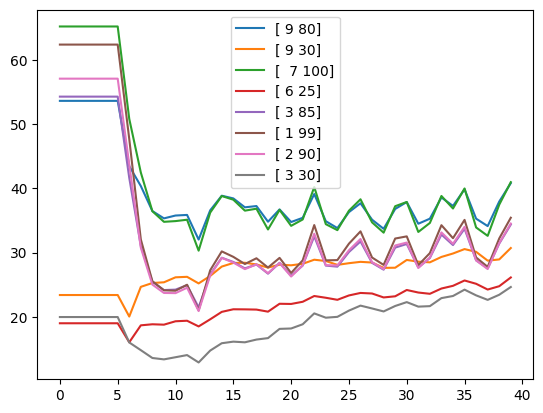

In [ ]:
for i in range(8):
  plt.plot(q_hist[:,i],label=f"{checks[i]}")

plt.legend()
plt.show()